# Variational Quantum EigenSolver (VQE) for the Hydrogen Molecule

In this tutorial, we'll explore the implementation of the Variational Quantum Eigensolver (VQE) algorithm to find the ground state energy of a hydrogen molecule (H2). We'll use various quantum computing frameworks including OpenFermion for molecular Hamiltonians, Qamomile for quantum circuit construction, and Qiskit for quantum simulation.

The workflow includes:
1. Converting molecular Hamiltonians to qubit operators
2. Creating a parametrized quantum circuit (ansatz)
3. Implementing VQE optimization
4. Analyzing the energy landscape at different atomic distances

We'll demonstrate how quantum computing can be used to solve quantum chemistry problems, specifically focusing on finding the minimum energy configuration of H2.

In [1]:
# You can install the required packages by running the following command
# !pip install openfermion pyscf openfermionpyscf

## Creating the Hamiltonian of the Hydrogen Molecule

In [1]:
import openfermion.chem as of_chem
import openfermion.transforms as of_trans
import openfermionpyscf as of_pyscf

In [2]:
basis = "sto-3g"
multiplicity = 1
charge = 0
distance = 0.977
geometry = [["H", [0, 0, 0]], ["H", [0, 0, distance]]]
description = "tmp"
molecule = of_chem.MolecularData(geometry, basis, multiplicity, charge, description)
molecule = of_pyscf.run_pyscf(molecule, run_scf=True, run_fci=True)
n_qubit = molecule.n_qubits
n_electron = molecule.n_electrons
fermionic_hamiltonian = of_trans.get_fermion_operator(molecule.get_molecular_hamiltonian())
jw_hamiltonian = of_trans.jordan_wigner(fermionic_hamiltonian)

## Convert to Qamomile Hamiltonian

In this section, we transform the OpenFermion Hamiltonian into a Qamomile Hamiltonian format. After applying the Jordan-Wigner transformation to convert fermionic operators to qubit operators, we use custom conversion functions to create a compatible Hamiltonian representation for Qamomile.

In [3]:
import qamomile.core.operator as qm_o

def operator_to_qamomile(operators: tuple[tuple[int, str], ...]) -> qm_o.Hamiltonian:
    pauli = {"X": qm_o.X, "Y": qm_o.Y, "Z": qm_o.Z}
    H = qm_o.Hamiltonian()
    H.constant = 1.0
    for ope in operators:
        H = H * pauli[ope[1]](ope[0])
    return H

def openfermion_to_qamomile(of_h) -> qm_o.Hamiltonian:
    H = qm_o.Hamiltonian()
    for k, v in of_h.terms.items():
        if len(k) == 0:
            H.constant += v
        else:
            H += operator_to_qamomile(k) * v
    return H

hamiltonian = openfermion_to_qamomile(jw_hamiltonian)

## Create VQE ansatz

In this section, we create a simple ansatz for the VQE algorithm. The ansatz is a parametrized quantum circuit that prepares a trial wavefunction. We use the Qamomile framework to construct the ansatz circuit.

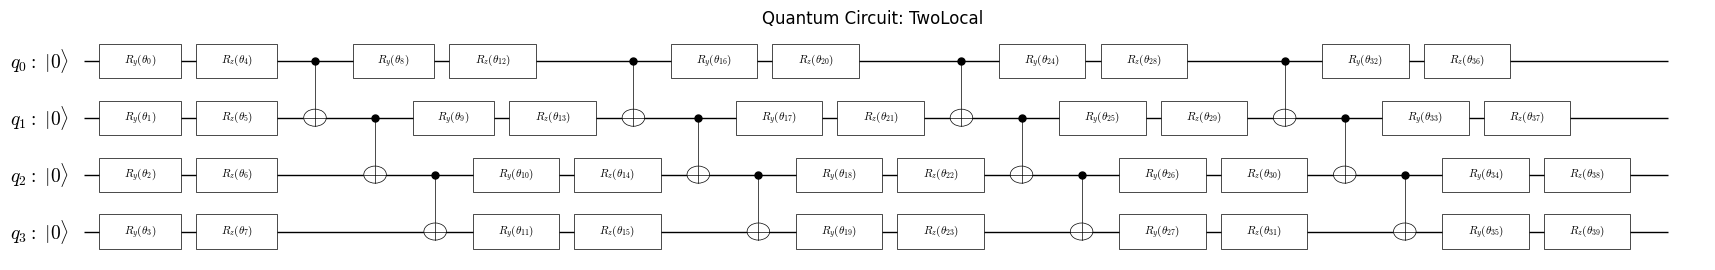

In [4]:
from qamomile.core.ansatz.efficient_su2 import create_efficient_su2_circuit
from qamomile.core.circuit.drawer import plot_quantum_circuit

ansatz = create_efficient_su2_circuit(
    hamiltonian.num_qubits, rotation_blocks=["ry", "rz"],
    reps=4, entanglement="linear"
)
plot_quantum_circuit(ansatz)

## Run VQE with Qiskit

In this section, we execute the VQE using the Qiskit Aer simulator after converting the Qamomile Hamiltonian and ansatz to Qiskit format.  
Of course, you can use other quantum computing frameworks.

In [5]:
import qamomile.qiskit as qm_qk

qk_transpiler = qm_qk.QiskitTranspiler()
qk_ansatz = qk_transpiler.transpile_circuit(ansatz)
qk_hamiltonian = qk_transpiler.transpile_hamiltonian(hamiltonian)

In [ ]:
# !pip install qiskit-aer

In [6]:
import qiskit.primitives as qk_pr
import qiskit as qk
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2
import numpy as np
from scipy.optimize import minimize

cost_history = []

aer_sim = AerSimulator()
qk_circuit_transpiled_ansatz = qk.transpile(qk_ansatz, aer_sim)
estimator = EstimatorV2()

def cost_estimator(param_values):
    job = estimator.run([(qk_ansatz, qk_hamiltonian, param_values)])
    result = job.result()[0]
    cost = result.data["evs"]
    return cost

def cost_callback(param_values):
    cost_history.append(cost_estimator(param_values))

initial_params = np.random.uniform(0, np.pi, len(qk_ansatz.parameters))

# Run QAOA optimization
result = minimize(
    cost_estimator,
    initial_params,
    method="BFGS",
    options={"disp": True, "maxiter": 50, "gtol": 1e-6},
    callback=cost_callback
)
print(result)

         Current function value: -1.105868
         Iterations: 50
         Function evaluations: 2091
         Gradient evaluations: 51
  message: Maximum number of iterations has been exceeded.
  success: False
   status: 1
      fun: -1.1058675315265363
        x: [ 3.157e+00  2.124e+00 ...  1.591e+00  4.345e-01]
      nit: 50
      jac: [ 5.545e-05  1.662e-04 ...  5.196e-04 -2.392e-05]
 hess_inv: [[ 6.494e+00 -2.618e+00 ...  1.032e+01 -6.820e-01]
            [-2.618e+00  9.130e+00 ... -5.761e+00  3.409e+00]
            ...
            [ 1.032e+01 -5.761e+00 ...  2.391e+01 -1.763e+00]
            [-6.820e-01  3.409e+00 ... -1.763e+00  2.796e+00]]
     nfev: 2091
     njev: 51


/Users/yuyamashiro/Library/Caches/pypoetry/virtualenvs/qamomile-s0Pfpxir-py3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:726: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


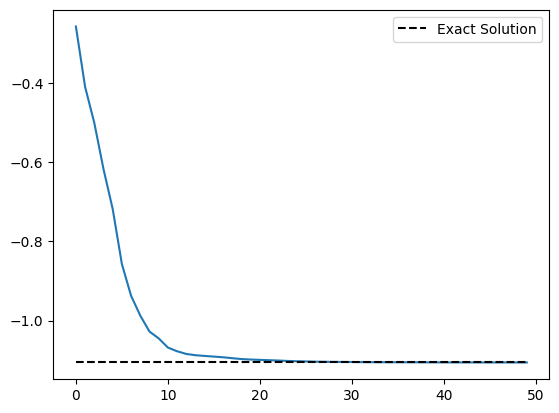

In [7]:
import matplotlib.pyplot as plt
plt.plot(cost_history)
plt.plot(
    range(len(cost_history)),
    [molecule.fci_energy] * len(cost_history),
    linestyle="dashed",
    color="black",
    label="Exact Solution",
)
plt.legend()
plt.show()

## Change distance between atoms

In [8]:
def hydrogen_molecule(bond_length):
    basis = "sto-3g"
    multiplicity = 1
    charge = 0
    geometry = [["H", [0, 0, 0]], ["H", [0, 0, bond_length]]]
    description = "tmp"
    molecule = of_chem.MolecularData(geometry, basis, multiplicity, charge, description)
    molecule = of_pyscf.run_pyscf(molecule, run_scf=True, run_fci=True)
    n_qubit = molecule.n_qubits
    n_electron = molecule.n_electrons
    fermionic_hamiltonian = of_trans.get_fermion_operator(
        molecule.get_molecular_hamiltonian()
    )
    jw_hamiltonian = of_trans.jordan_wigner(fermionic_hamiltonian)
    return openfermion_to_qamomile(jw_hamiltonian), molecule.fci_energy

bond_lengths = np.linspace(0.2, 1.5, 15)
energies = []
for bond_length in bond_lengths:
    hamiltonian, fci_energy = hydrogen_molecule(bond_length)
    
    ansatz = create_efficient_su2_circuit(
        hamiltonian.num_qubits, rotation_blocks=["ry", "rz"],
        reps=4, entanglement="linear"
    )

    qk_ansatz = qk_transpiler.transpile_circuit(ansatz)
    qk_hamiltonian = qk_transpiler.transpile_hamiltonian(hamiltonian)

    cost_history = []
    initial_params = np.random.uniform(0, np.pi, len(qk_ansatz.parameters))
    result = minimize(
        cost_estimator,
        initial_params,
        method="BFGS",
        options={"maxiter": 50, "gtol": 1e-6},
    )

    energies.append(result.fun)

    print("distance: ", bond_length, "energy: ", result.fun, "fci_energy: ", fci_energy)

distance:  0.2 energy:  0.15754119488608387 fci_energy:  0.15748213479836348
distance:  0.29285714285714287 energy:  -0.5679350331466697 fci_energy:  -0.5679447209710022
distance:  0.38571428571428573 energy:  -0.8833020521044717 fci_energy:  -0.8833596636183383
distance:  0.4785714285714286 energy:  -1.0335991644424345 fci_energy:  -1.0336011797110967
distance:  0.5714285714285714 energy:  -1.1035710721430323 fci_energy:  -1.1042094222435161
distance:  0.6642857142857144 energy:  -1.1322058758760072 fci_energy:  -1.132350882707551
distance:  0.7571428571428571 energy:  -1.136784862771528 fci_energy:  -1.1369026717971324
distance:  0.8500000000000001 energy:  -1.1281267827080066 fci_energy:  -1.1283618784581124
distance:  0.9428571428571428 energy:  -1.1125670649192354 fci_energy:  -1.1127252078468768
distance:  1.0357142857142858 energy:  -1.093269672823594 fci_energy:  -1.0934760882294043
distance:  1.1285714285714286 energy:  -1.0725622262836512 fci_energy:  -1.0727578805453502
dist

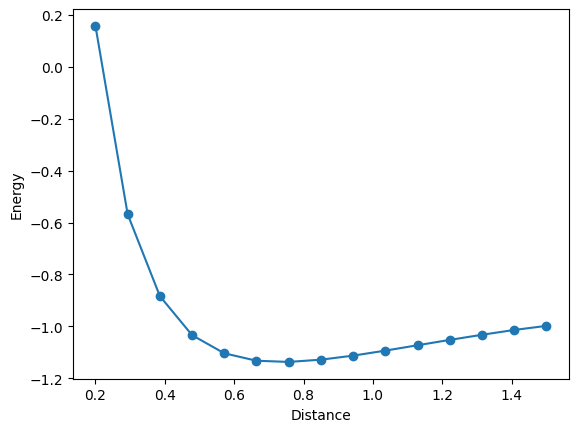

In [9]:
plt.plot(bond_lengths, energies, "-o")
plt.xlabel("Distance")
plt.ylabel("Energy")
plt.show()